In [ ]:
import numpy as np
import ceviche_challenges
from ceviche_challenges import units as u
import ceviche
from inverse_design.brushes import notched_square_brush, circular_brush
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange

import autograd
import autograd.numpy as npa

In [ ]:
import jax
import jax.numpy as jnp
from javiche import jaxit
import matplotlib.pylab as plt
import numpy as np
from inverse_design.conditional_generator import generate_feasible_design_mask
from jax.example_libraries.optimizers import adam

In [ ]:
spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
  wg_width=400*u.nm, variable_region_size=(1600*u.nm, 1600*u.nm), cladding_permittivity=2.25
)
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 25 * u.nm)
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

In [ ]:
def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush) #.reshape((Nx, Ny))
    latent_t = latent_t + jnp.transpose(latent_t)
    design_mask = generate_feasible_design_mask(latent_t, 
      brush) #, verbose=False
    design = (design_mask+1.0)/2.0
    return design

In [ ]:
brush = circular_brush(5)
latent = new_latent_design(model.design_variable_shape, bias=0.1, r=1, r_scale=4e-1)

In [ ]:
@jaxit(cache=True)
def inner_loss_fn(design):
    s_params, fields = model.simulate(design)
    s11 = npa.abs(s_params[:, 0, 0])
    s21 = npa.abs(s_params[:, 0, 1])
    
    global debug_fields, debug_design, debug_forward
    debug_fields = fields
    debug_design = design
    debug_forward = isinstance(design, np.ndarray)

    return npa.mean(s11) - npa.mean(s21)

def loss_fn(latent):
    design = forward(latent, brush)
    return inner_loss_fn(design)

In [ ]:
# Number of epochs in the optimization
Nsteps = 150
# Step size for the Adam optimizer
def step_size(idx):
  """reducing the stepsize linearly for Nsteps (stabilize afterwards just in case)"""
  start = 0.1
  stop = 5e-3
  return start*(stop/start)**(idx/Nsteps)

#step_size = 0.01

In [ ]:
def visualize_latent(latent):
  global debug_design, debug_fields, debug_forward
  design = forward(latent, brush)
  s_params, fields = model.simulate(design)
  debug_design = design
  debug_fields = fields
  debug_forward = True
  visualize_debug()

def visualize_debug():
  global debug_design, debug_fields, debug_forward
  if not isinstance(debug_fields, np.ndarray):
    debug_fields = debug_fields._value
    debug_design = debug_design._value
  
  if debug_forward:
    plt.figure(figsize=(1,1))
    ax = plt.gca()
    ceviche.viz.abs(np.squeeze(np.asarray(debug_fields)), model.density(np.asarray(debug_design)), ax=ax)
    plt.grid()
    plt.axis("off")
    plt.show()

In [ ]:
grad_fn = jax.grad(loss_fn)

init_fn, update_fn, params_fn = adam(step_size)
state = init_fn(latent) #.flatten()
#value_and_grad seems to have a problem. Figure out why!

def step_fn(step, state):
    latent = params_fn(state) # we need autograd arrays here...
    grads = grad_fn(latent)
    loss = loss_fn(latent)
    #loss = loss_fn(latent)

    optim_state = update_fn(step, grads, state)
    # optim_latent = params_fn(optim_state)
    # optim_latent = optim_latent/optim_latent.std()

    visualize_debug()
    return loss, optim_state

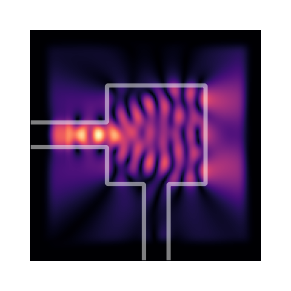

In [ ]:
latent = params_fn(state)
visualize_latent(latent)

In [ ]:
losses = np.ndarray(Nsteps)

  0%|          | 0/150 [00:00<?, ?it/s]

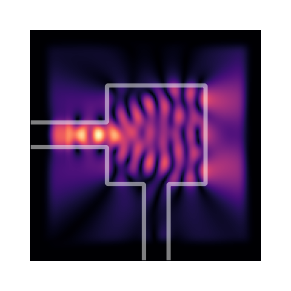

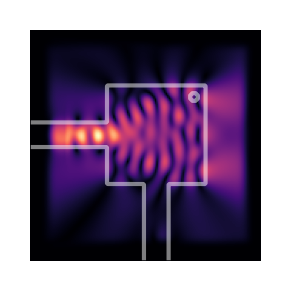

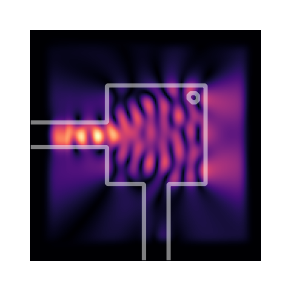

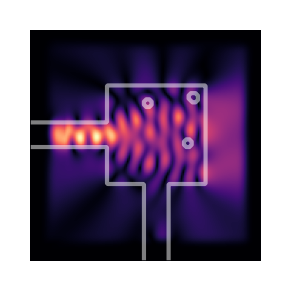

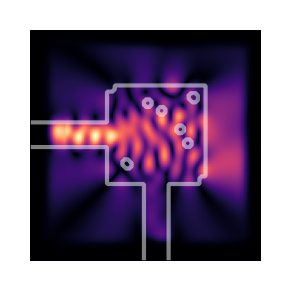

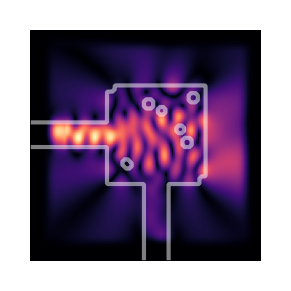

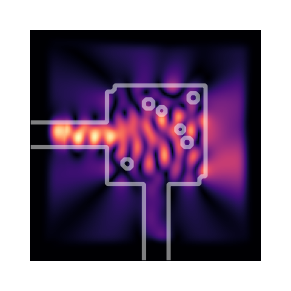

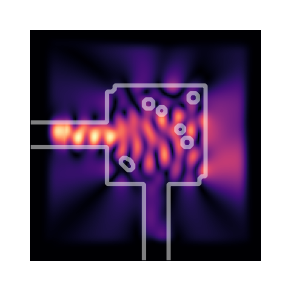

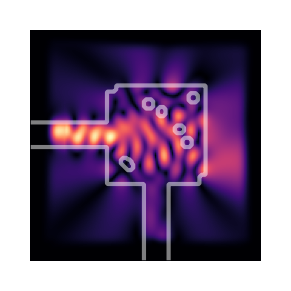

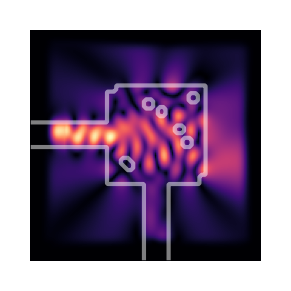

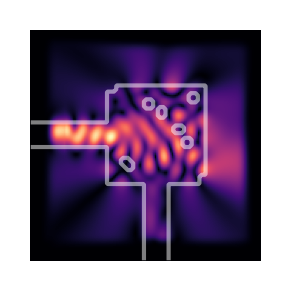

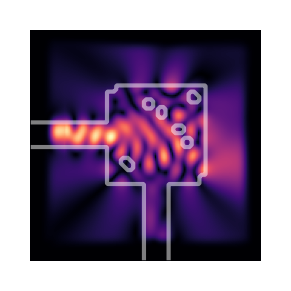

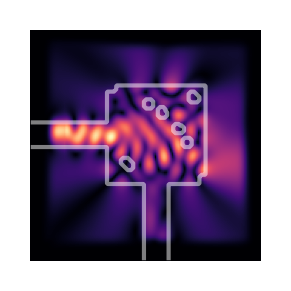

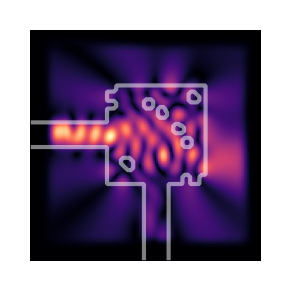

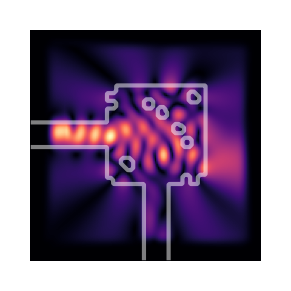

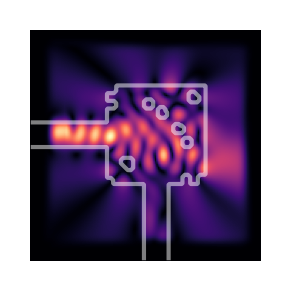

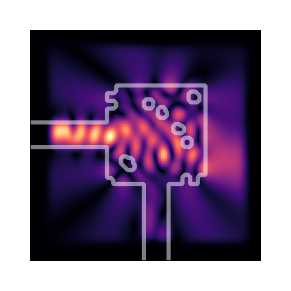

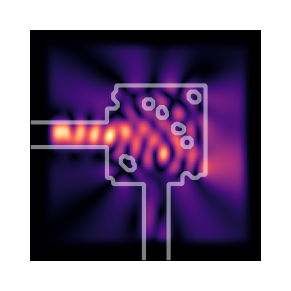

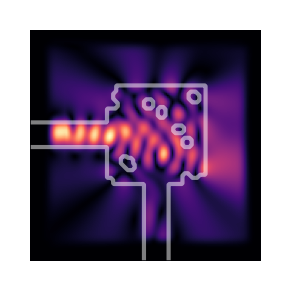

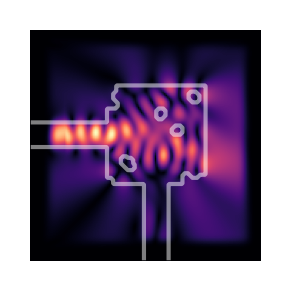

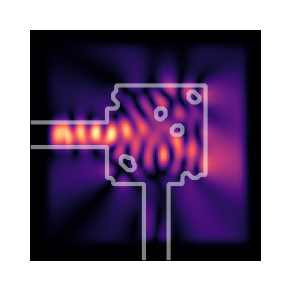

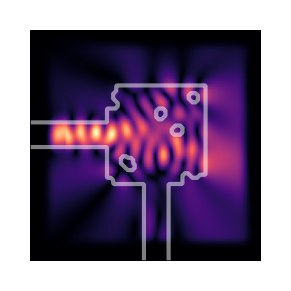

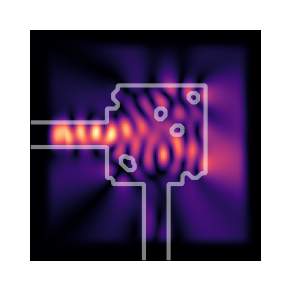

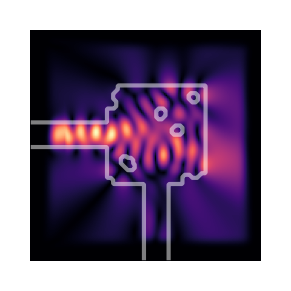

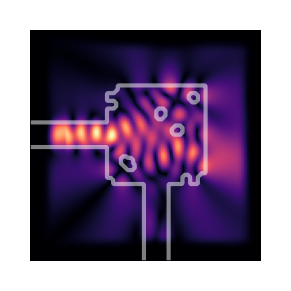

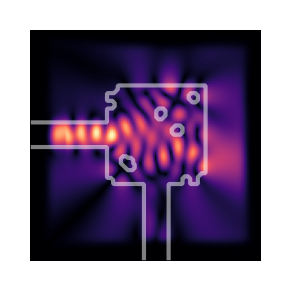

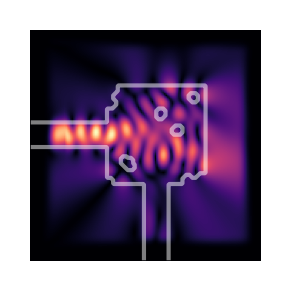

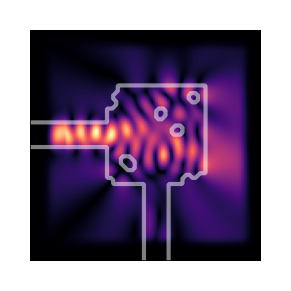

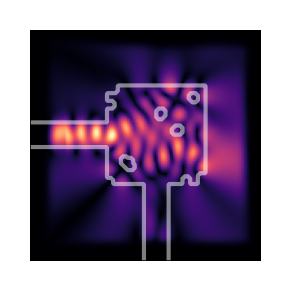

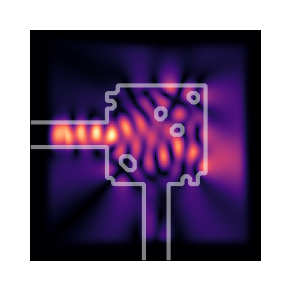

In [ ]:
#|eval:false
range_ = trange(Nsteps)
for step in range_:
    loss, state = step_fn(step, state)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))

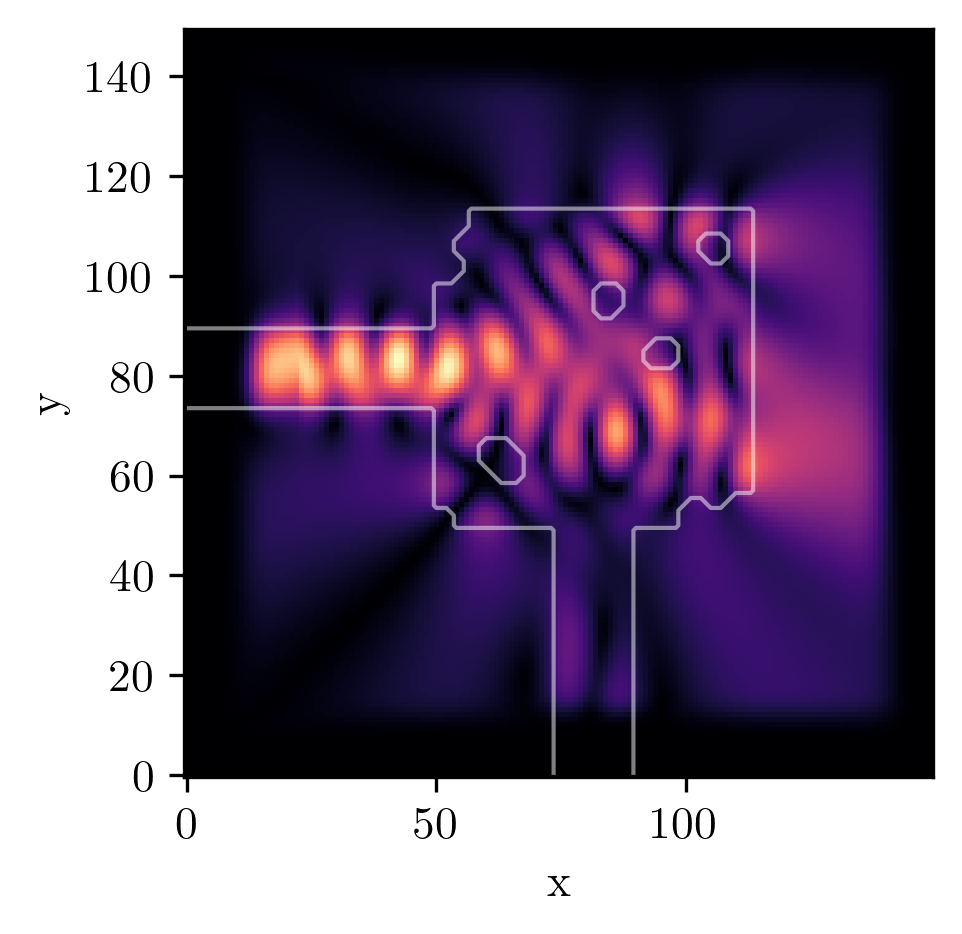

In [ ]:
latent = params_fn(state)
design = forward(latent, brush)
s_params, fields = model.simulate(design)
epsr = model.epsilon_r(design)
ceviche.viz.abs(np.squeeze(fields), model.density(design))
plt.grid()

[<matplotlib.lines.Line2D>]

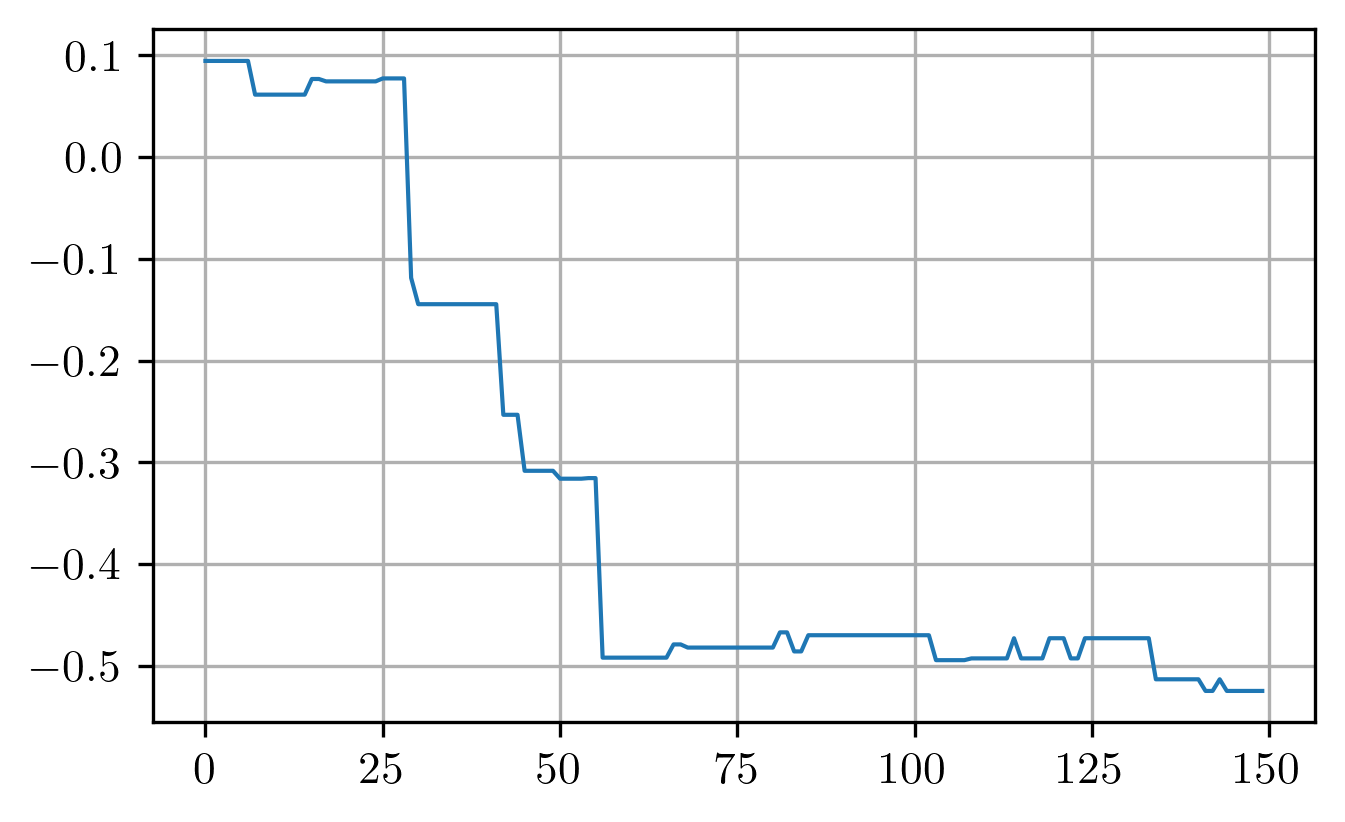

In [ ]:
plt.plot(losses)